<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/RNN_model/RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
final_2018_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/final_2018_2021.csv', encoding='euc-kr')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


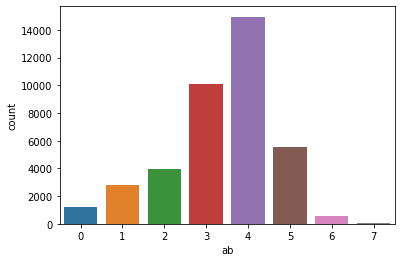

In [ ]:
sns.countplot(final_2018_2021['ab'])
plt.show()

In [43]:
#선발 출장에 한정
final_2018_2021 = final_2018_2021[final_2018_2021['start_member'] == 1]

In [44]:
#3월, 4월 데이터 제외
final_2018_2021 = final_2018_2021.loc[final_2018_2021['day']>= 500]

In [45]:
#0타수 데이터 제외
final_2018_2021 = final_2018_2021[final_2018_2021['ab']>0]

### **Multi layer Perceptron in Be the legend**

In [158]:
mlp_data = final_2018_2021.loc[:, ['name', 'day', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [11]:
len(mlp_data)

29395

In [12]:
len(mlp_data[mlp_data['result_y'] == 1]) / len(mlp_data) * 100

67.47065827521688

In [13]:
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.preprocessing import minmax_scale
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

### **Training data set / Test data set 분할**

In [364]:
mlp_train, mlp_test = train_test_split(mlp_data, test_size=0.15, random_state=50)

In [365]:
#현재 가지고 있는 모든 피쳐 사용

X_train = mlp_train.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_train = mlp_train.loc[:, ['result_y']]

X_test = mlp_test.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_test = mlp_test.loc[:, ['result_y']]

In [366]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [367]:
X_train = minmax_scale(X_train, feature_range=(0,1), axis = 0)
X_test = minmax_scale(X_test, feature_range=(0,1), axis = 0)

In [368]:
number_of_train_samples = X_train.shape[0]
width = X_train.shape[1]
X_train = X_train.reshape(number_of_train_samples, 1, width)

In [369]:
number_of_test_samples = X_test.shape[0]
X_test = X_test.reshape(number_of_test_samples, 1, width)

In [370]:
X_train.shape, X_test.shape

((24985, 1, 13), (4410, 1, 13))

### **Stratified K-Fold Cross Validation (auto)**

In [283]:
mlp_data = final_2018_2021.loc[:, ['name', 'day', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [284]:
X = mlp_data.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y = mlp_data.loc[:, ['result_y']]

In [285]:
X = X.to_numpy()
y = y.to_numpy()

In [286]:
X = minmax_scale(X, feature_range=(0,1), axis = 0)

In [287]:
number_of_samples = X.shape[0]
width = X.shape[1]
X = X.reshape(number_of_samples, 1, width)

In [288]:
X.shape, y.shape

((29395, 1, 13), (29395, 1))

In [289]:
def gru_k():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(50, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [290]:
model = KerasClassifier(build_fn=gru_k, epochs=150, batch_size=32, verbose=0)  

In [291]:
 kfold = KFold(n_splits = 5, shuffle = True, random_state = 50) 
 results = cross_val_score(model, X, y, cv=kfold)

In [292]:
results, round(np.mean(results),3)

(array([0.81714576, 0.81323355, 0.80898112, 0.81459433, 0.8031978 ]), 0.811)

### **Validation data set / Training data set 분할**

In [200]:
X_val = X_train[:5000]
X_train = X_train[5000:]

y_val = y_train[:5000]
y_train = y_train[5000:]

### **SimpleRNN**

In [301]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, LSTM
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

**model_2**

In [340]:
def simple_rnn2():
    model = Sequential()
    model.add(SimpleRNN(32, input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [341]:
model2 = simple_rnn2()
history = model2.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict2 = history.history

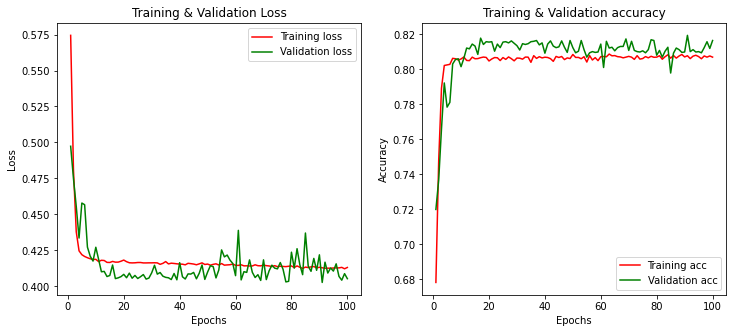

In [342]:
loss_acc_graph(history_dict2)

In [343]:
results = model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4053 - acc: 0.8166
Test accuracy:  0.8165532946586609


**model_3**

In [351]:
def simple_rnn3():
    model = Sequential()
    model.add(SimpleRNN(32, input_shape = (1,13), return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [352]:
model3 = simple_rnn3()
history = model3.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict3 = history.history

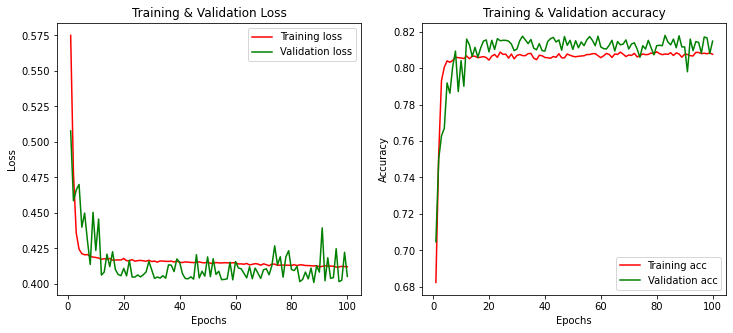

In [353]:
loss_acc_graph(history_dict3)

In [354]:
results = model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4053 - acc: 0.8147
Test accuracy:  0.8147392272949219


**model_4**

In [362]:
def simple_rnn4():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True))
    model.add(SimpleRNN(32, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [363]:
model4 = simple_rnn4()
history = model4.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict4 = history.history

KeyboardInterrupt: ignored

In [ ]:
results = model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 2ms/step - loss: 0.4010 - acc: 0.8159
Test accuracy:  0.815852165222168


**model_5**

In [ ]:
def simple_rnn5():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True, activation='relu'))
    model.add(SimpleRNN(32, return_sequences = False, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model5 = simple_rnn5()
history = model5.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = model5.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 2ms/step - loss: 0.4056 - acc: 0.8163
Test accuracy:  0.8163056969642639


**model_6**

In [ ]:
def simple_rnn6():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True, activation='tanh'))
    model.add(SimpleRNN(32, return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model6 = simple_rnn6()
history = model6.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = model6.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 2ms/step - loss: 0.4001 - acc: 0.8161
Test accuracy:  0.8160789012908936


**model_7**

In [ ]:
def simple_rnn7():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True, activation='sigmoid'))
    model.add(SimpleRNN(32, return_sequences = False, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model7 = simple_rnn7()
history = model7.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = model7.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 1ms/step - loss: 0.4006 - acc: 0.8153
Test accuracy:  0.8152852058410645


**model_8**

In [ ]:
def simple_rnn8():
    model = Sequential()
    model.add(SimpleRNN(48, input_shape = (1,13), return_sequences = True, activation='tanh'))
    model.add(SimpleRNN(10, return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model8 = simple_rnn8()
history = model8.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = model8.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 1ms/step - loss: 0.3991 - acc: 0.8168
Test accuracy:  0.8167592883110046


### **LSTM**

**LSTM_model_1**

In [36]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Embedding, LSTM
from keras import optimizers

In [34]:
def lstm1():
    model = Sequential()
    model.add(LSTM(48, input_shape = (1,13), return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [35]:
ltsm_model1 = lstm1()
history = ltsm_model1.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

NameError: ignored

In [ ]:
results = ltsm_model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

**LSTM_model_2**

In [ ]:
def lstm2():
    model = Sequential()
    model.add(LSTM(20, input_shape = (1,13), return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model2 = lstm2()
history = ltsm_model2.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = ltsm_model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

**LSTM_model_3**

In [ ]:
def lstm3():
    model = Sequential()
    model.add(LSTM(50, input_shape = (1,13), return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model3 = lstm3()
history = ltsm_model3.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = ltsm_model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

**LSTM_model_4**

In [ ]:
def lstm4():
    model = Sequential()
    model.add(LSTM(50, input_shape = (1,13), return_sequences = True))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model4 = lstm4()
history = ltsm_model4.fit(X_train, y_train, epochs = 150, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = ltsm_model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

**LSTM_model_5**

In [ ]:
def lstm5():
    model = Sequential()
    model.add(LSTM(32, input_shape = (1,13), return_sequences = True, activation='tanh'))
    model.add(LSTM(16, return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model5 = lstm5()
history = ltsm_model5.fit(X_train, y_train, epochs = 150, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = ltsm_model5.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

**LSTM_model_6**

In [ ]:
def lstm6():
    model = Sequential()
    model.add(LSTM(20, input_shape = (1,13), return_sequences = True))
    model.add(LSTM(20, return_sequences = True))
    model.add(LSTM(20, return_sequences = True))
    model.add(LSTM(20, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model6 = lstm6()
history = ltsm_model6.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = ltsm_model6.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

**LSTM_model_7**

In [ ]:
def lstm7():
    model = Sequential()
    model.add(LSTM(40, input_shape = (1,13), return_sequences = True, activation='tanh'))
    model.add(LSTM(40, return_sequences = True, activation='tanh'))
    model.add(LSTM(30, return_sequences = True, activation='tanh'))
    model.add(LSTM(20, return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model7 = lstm7()
history = ltsm_model7.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
results = ltsm_model7.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

### **Bidirectional LSTM**

**양방향 LSTM model_1**

In [52]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Embedding, LSTM
from keras import optimizers

In [81]:
def bidirectional_lstm1():
    model = Sequential()
    model.add(Bidirectional(LSTM(13, return_sequences = False), input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [82]:
bidirectional_model1 = bidirectional_lstm1()
history = bidirectional_model1.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [83]:
results = bidirectional_model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 2ms/step - loss: 0.3977 - acc: 0.8155
Test accuracy:  0.81551194190979


**양방향 LSTM model_2**

In [77]:
def bidirectional_lstm2():
    model = Sequential()
    model.add(Bidirectional(LSTM(40, return_sequences = False), input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [78]:
bidirectional_model2 = bidirectional_lstm2()
history = bidirectional_model2.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [80]:
results = bidirectional_model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 1s 3ms/step - loss: 0.3974 - acc: 0.8164
Test accuracy:  0.8164191246032715


**양방향 LSTM model_3**

In [117]:
def bidirectional_lstm3():
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences = True), input_shape = (1,13)))
    model.add(Bidirectional(LSTM(20, return_sequences = False)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [118]:
bidirectional_model3 = bidirectional_lstm3()
history = bidirectional_model3.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [120]:
results = bidirectional_model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 1s 2ms/step - loss: 0.7155 - acc: 0.6163
Test accuracy:  0.6162829995155334


**심층 양방향 LSTM model_4**

In [93]:
def bidirectional_lstm4():
    model = Sequential()
    model.add(Bidirectional(LSTM(40, return_sequences = True), input_shape = (1,13)))
    model.add(Bidirectional(LSTM(40, return_sequences = True)))
    model.add(Bidirectional(LSTM(40, return_sequences = False)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [94]:
bidirectional_model4 = bidirectional_lstm4()
history = bidirectional_model4.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [96]:
results = bidirectional_model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 1s 2ms/step - loss: 0.4141 - acc: 0.8121
Test accuracy:  0.8121102452278137


### **GRU**

**GRU model_1**

In [273]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Embedding, LSTM, GRU, Bidirectional, CuDNNGRU,GRU
from keras import optimizers

In [234]:
def gru1():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [235]:
gru_model1 = gru1()
history = gru_model1.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict = history.history

In [236]:
results = gru_model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

92/92 [==============================] - 0s 1ms/step - loss: 0.4084 - acc: 0.8102
Test accuracy:  0.8102040886878967


**GRU model_2**

In [137]:
def gru2():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [138]:
gru_model2 = gru2()
history = gru_model2.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [140]:
results = gru_model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 1ms/step - loss: 0.4117 - acc: 0.8068
Test accuracy:  0.8067808151245117


**GRU model_3**

In [23]:
def gru3():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(50, return_sequences = True))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [24]:
gru_model3 = gru3()
history = gru_model3.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [27]:
results = gru_model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 2ms/step - loss: 0.4025 - acc: 0.8159
Test accuracy:  0.815852165222168


**GRU model_4**

In [38]:
def gru4():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(50, return_sequences = True))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [39]:
gru_model4 = gru4()
history = gru_model4.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [41]:
results = gru_model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 0s 2ms/step - loss: 0.1288 - acc: 0.8176
Test accuracy:  0.8175529837608337


**GRU model_5**

In [79]:
def gru5():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(50, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [80]:
gru_model5 = gru5()
history = gru_model5.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [82]:
results = gru_model5.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

276/276 [==============================] - 1s 2ms/step - loss: 0.4007 - acc: 0.8185
Test accuracy:  0.8184601664543152


**GRU model_6**

In [244]:
def gru6():
    model = Sequential()
    model.add(Bidirectional(GRU(50, input_shape = (1,13), return_sequences = True)))
    model.add(Bidirectional(GRU(50, return_sequences = True)))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
gru_model6 = gru6()
history = gru_model6.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict = history.history

In [249]:
results = gru_model6.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

92/92 [==============================] - 0s 2ms/step - loss: 0.4100 - acc: 0.8082
Test accuracy:  0.8081632852554321


### **Loss & Acc graph**







In [293]:
def loss_acc_graph(history_dict):
  # history_dict = history.history

  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  epochs = range(1, len(loss)+1)

  plt.figure(figsize=(12,5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'red', label='Training loss') 
  plt.plot(epochs, val_loss, 'green', label='Validation loss')
  plt.title('Training & Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'red', label='Training acc') 
  plt.plot(epochs, val_acc, 'green', label='Validation acc')
  plt.title('Training & Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()